In [1]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB7
import matplotlib.pyplot as plt

In [2]:
# 1. Metadata Preprocessing
metadata_path = 'train.csv'
metadata_df = pd.read_csv(metadata_path)

# Function to clean and normalize poster filenames
def clean_filename(title):
    # Remove unwanted special characters except for - and '.
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title) 
    return title

# Generate normalized filenames by combining the title and year
metadata_df['Poster_Filename'] = metadata_df['Title'].apply(clean_filename) + '_' + metadata_df['Year'].astype(str) + '.jpg'

In [3]:
# 2. Poster Processing
poster_folder = 'posters_train'
image_size = (300, 300)

# Process images
X_images = []
for filename in metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder, filename)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB') # Open and convert to RGB
        img = img.resize(image_size)
        img = np.array(img) / 255.0  # Normalize [0,1]
        X_images.append(img)
    else:
        # Append random noise for missing images
        X_images.append(np.random.normal(0.5, 0.1, (*image_size, 3)))  # Gürültülü resim

X_images = np.array(X_images)

In [5]:
# 3. Metadata Processing
# Scale numerical features
numerical_features = ['Runtime(min)', 'Budget']
scaler = StandardScaler()
X_numeric = scaler.fit_transform(metadata_df[numerical_features].values)

# Encode categorical features using LabelEncoder
categorical_features = ['Director', 'Country', 'Genre1', 'Genre2', 'Genre3', 'Actor1', 'Actor2', 'Actor3']
encoders = {}
X_categorical = []
for feature in categorical_features:
    le = LabelEncoder()
    metadata_df[feature] = le.fit_transform(metadata_df[feature]) # Encode feature
    X_categorical.append(metadata_df[feature].values)
    encoders[feature] = le

X_categorical = np.column_stack(X_categorical)# Combine categorical features into one array

# Log-transform target variable (BoxOffice) to reduce skewness
Y = np.log1p(metadata_df['BoxOffice'].values)

In [6]:

# Split the dataset into training and validation sets
X_img_train, X_img_val, X_num_train, X_num_val, X_cat_train, X_cat_val, Y_train, Y_val = train_test_split(
    X_images, X_numeric, X_categorical, Y, test_size=0.2, random_state=42)

In [7]:
# Model Definition
# 1. EfficientNetB7 for Poster Feature Extraction
image_input = layers.Input(shape=(300, 300, 3)) # Define input for image data
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False # Freeze pre-trained weights

x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

In [8]:
# 2. MLP for Metadata Processing
metadata_input = layers.Input(shape=(X_numeric.shape[1] + X_categorical.shape[1],))  # Define metadata input
y = layers.Dense(128, activation='relu')(metadata_input)  # Hidden layer with 128 units
y = layers.Dropout(0.3)(y)  # Dropout for regularization
y = layers.Dense(64, activation='relu')(y)  # Hidden layer with 64 units
y = layers.Dropout(0.3)(y)

In [9]:
# 3. Combine Poster and Metadata Features
combined = layers.concatenate([x, y])  # Concatenate processed features
output = layers.Dense(1)(combined)  # Output layer for regression task


In [10]:
# Compile the model
optimizer_adamw = optimizers.AdamW(learning_rate=0.0005)  # Use AdamW optimizer
model = models.Model(inputs=[image_input, metadata_input], outputs=output)  # Create model
model.compile(optimizer=optimizer_adamw, loss='mean_squared_error', metrics=['mae'])  # Compile with MSE loss


In [11]:
# Model Training
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Early stopping to prevent overfitting
history = model.fit([X_img_train, np.hstack([X_num_train, X_cat_train])], Y_train,
                    validation_data=([X_img_val, np.hstack([X_num_val, X_cat_val])], Y_val),
                    epochs=100, batch_size=16, callbacks=[callback])

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 211.6014 - mae: 11.3818 - val_loss: 35.4334 - val_mae: 5.1429
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 57.8377 - mae: 6.1636 - val_loss: 19.7262 - val_mae: 3.8628
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 26.8316 - mae: 4.1386 - val_loss: 14.7844 - val_mae: 3.3952
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 19.8027 - mae: 3.6043 - val_loss: 12.4246 - val_mae: 3.1701
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 13.9206 - mae: 2.9809 - val_loss: 7.0249 - val_mae: 2.2268
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 9.3976 - mae: 2.4232 - val_loss: 7.6906 - val_mae: 2.4690
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 9.3242 - mae: 2.4541 - val_loss: 5.9808 - val_mae: 2.0778
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 8.3726 - mae: 2.2607 - val_loss: 5.4409 - val_mae: 1.9348
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 124s 2

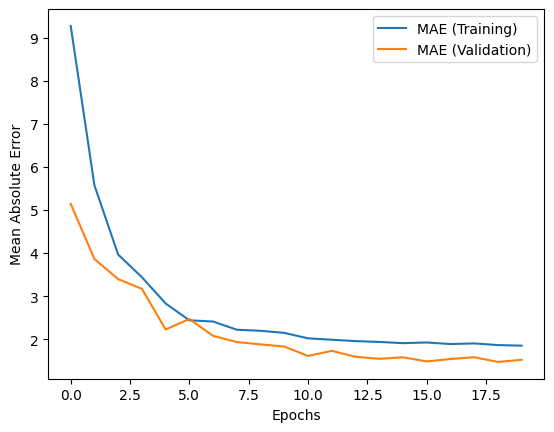

Model eğitimi ve analizi tamamlandı.


In [12]:
# Performance Analysis
plt.figure()
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [13]:
# Test Data Preprocessing
test_metadata_path = 'test.csv'
test_metadata_df = pd.read_csv(test_metadata_path)

# Normalize poster filenames for test data
def clean_filename(title):
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title)  # Adjusted special character removal
    return title

test_metadata_df['Poster_Filename'] = test_metadata_df['Title'].apply(clean_filename) + '_' + test_metadata_df['Year'].astype(str) + '.jpg'

In [19]:
# Process test images
poster_folder2 = 'posters_test'
image_size = (300, 300)
X_test_images = []
for filename in test_metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder2, filename)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB') # Open and convert to RGB
        img = img.resize(image_size) # Resize the image
        img = np.array(img) / 255.0  # Normalize [0,1]
        X_test_images.append(img)
    else:
        print(filename)
        X_test_images.append(np.random.normal(0.5, 0.1, (*image_size, 3)))  # Gürültülü resim

X_test_images = np.array(X_test_images)

In [21]:
# Process numerical and categorical test metadata

X_test_numeric = scaler.fit_transform(test_metadata_df[numerical_features].values)


In [22]:
X_test_categorical = []
for feature in categorical_features:
    # Use previously saved encoder
    encoder = encoders[feature]
    test_labels = test_metadata_df[feature]

    # Handle unseen labels by assigning them to an "Unknown" category
    test_labels = test_labels.apply(lambda x: x if x in encoder.classes_ else 'Unknown')

    
    if 'Unknown' not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, 'Unknown')

    # Encode işlemi
    X_test_categorical.append(encoder.transform(test_labels))
X_test_categorical = np.column_stack(X_test_categorical)


In [23]:
# Log-transform BoxOffice values for evaluation
Y_test_actual = np.log1p(test_metadata_df['BoxOffice'].values)

In [24]:
# Generate predictions on test set
Y_test_pred = model.predict([X_test_images, np.hstack([X_test_numeric, X_test_categorical])])

# Evaluate performance using MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test_actual, Y_test_pred)
mae = mean_absolute_error(Y_test_actual, Y_test_pred)

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Test Set MSE: 3.8371
Test Set MAE: 1.5505
